# Executing QIR programs

If you have a QIR string or bitcode, you can start by creating a Pulla-compatible circuit representation.

In [1]:
import os
from qiskit import QuantumCircuit, visualization
from iqm.qiskit_iqm import IQMProvider
from iqm.pulla.pulla import Pulla
from iqm.pulla.utils_qiskit import sweep_job_to_qiskit
from iqm.pulla.utils_qir import qir_to_pulla

In [ ]:
# Create a Pulla object and a qiskit-iqm backend for accessing the quantum computer.
iqm_server_url = os.environ['PULLA_IQM_SERVER_URL']  # or set the URL directly here
os.environ["IQM_TOKEN"] = os.environ.get("IQM_TOKEN")  # or set the token directly here

p = Pulla(iqm_server_url)
provider = IQMProvider(iqm_server_url)
backend = provider.get_backend()

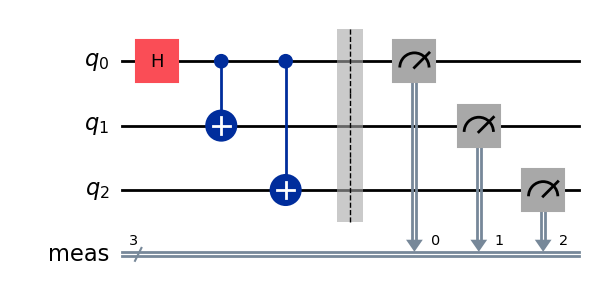

In [3]:
# Define a quantum circuit (for visualization).
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.measure_all()
qc.draw(output='mpl')

In [5]:
# Define a QIR
qir = """
; ModuleID = 'circuit-166'
source_filename = "circuit-166"

%Qubit = type opaque
%Result = type opaque

define void @circuit-166() #0 {
entry:
  call void @__quantum__rt__initialize(i8* null)
  call void @__quantum__qis__r__body(double 0x3FF921FB54442D1A, double 0x4012D97C7F3321D2, %Qubit* inttoptr (i64 1 to %Qubit*))
  call void @__quantum__qis__r__body(double 0x3FF921FB54442D1A, double 0x4012D97C7F3321D2, %Qubit* inttoptr (i64 2 to %Qubit*))
  call void @__quantum__qis__r__body(double 0x3FF921FB54442D1A, double 0x4012D97C7F3321D2, %Qubit* null)
  call void @__quantum__qis__cz__body(%Qubit* inttoptr (i64 1 to %Qubit*), %Qubit* null)
  call void @__quantum__qis__r__body(double 0x3FF921FB54442D1A, double 0x401F6A7A2955385E, %Qubit* inttoptr (i64 1 to %Qubit*))
  call void @__quantum__qis__cz__body(%Qubit* inttoptr (i64 2 to %Qubit*), %Qubit* null)
  call void @__quantum__qis__r__body(double 0x3FF921FB54442D1A, double 0x401F6A7A2955385E, %Qubit* inttoptr (i64 2 to %Qubit*))
  call void @__quantum__qis__mz__body(%Qubit* null, %Result* null)
  call void @__quantum__qis__mz__body(%Qubit* inttoptr (i64 1 to %Qubit*), %Result* inttoptr (i64 1 to %Result*))
  call void @__quantum__qis__mz__body(%Qubit* inttoptr (i64 2 to %Qubit*), %Result* inttoptr (i64 2 to %Result*))
  call void @__quantum__rt__array_record_output(i64 3, i8* null)
  call void @__quantum__rt__result_record_output(%Result* inttoptr (i64 2 to %Result*), i8* null)
  call void @__quantum__rt__result_record_output(%Result* inttoptr (i64 1 to %Result*), i8* null)
  call void @__quantum__rt__result_record_output(%Result* null, i8* null)
  ret void
}

declare void @__quantum__rt__initialize(i8*)

declare void @__quantum__qis__r__body(double, double, %Qubit*)

declare void @__quantum__qis__cz__body(%Qubit*, %Qubit*)

declare void @__quantum__qis__mz__body(%Qubit*, %Result* writeonly) #1

declare void @__quantum__rt__array_record_output(i64, i8*)

declare void @__quantum__rt__result_record_output(%Result*, i8*)

attributes #0 = { "entry_point" "output_labeling_schema" "qir_profiles"="custom" "required_num_qubits"="4" "required_num_results"="3" }
attributes #1 = { "irreversible" }

!llvm.module.flags = !{!0, !1, !2, !3}

!0 = !{i32 1, !"qir_major_version", i32 1}
!1 = !{i32 7, !"qir_minor_version", i32 0}
!2 = !{i32 1, !"dynamic_qubit_management", i1 false}
!3 = !{i32 1, !"dynamic_result_management", i1 false}
"""

In [6]:
# Map the QIR qubits to the physical qubits of the QPU
qubits = ["QB3", "QB1", "QB2", "QB5"]
qubits_mapping = {str(i): qubit for i, qubit in enumerate(qubits)}
print(qubits_mapping)

{'0': 'QB3', '1': 'QB1', '2': 'QB2', '3': 'QB5'}


## Executing QIR

[11-13 13:56:54;I] Required number of qubits: 4
[11-13 13:56:54;I] Required number of results: 3
[11-13 13:56:54;I] QIR version: 1.0
[11-13 13:56:54;I] Submitted a job with ID: 019a7d13-64a8-7e91-bbf2-497b5ac59545
[11-13 13:56:54;I] Waiting for job 019a7d13-64a8-7e91-bbf2-497b5ac59545 to finish...


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Qiskit result counts: {'0 0 0': 1894, '0 1 1': 341, '1 1 0': 104, '1 1 1': 1449, '1 0 1': 498, '1 0 0': 311, '0 1 0': 277, '0 0 1': 126}


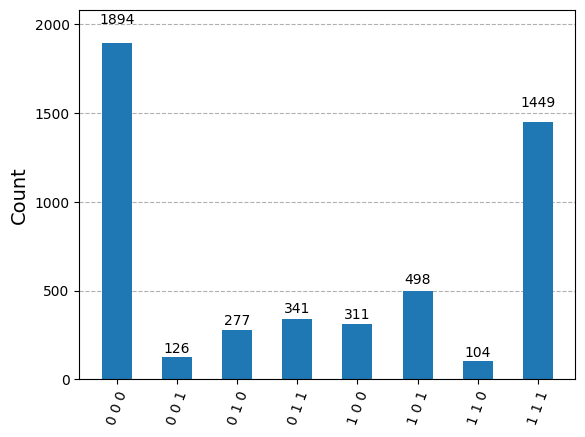

In [6]:
p = Pulla(iqm_server_url)
# Pass qubit mapping to qir_to_pulla converter to correctly interpret opaque qubit pointer indices in QIR
# and convert them to physical IQM qubit names.
circuits, compiler = qir_to_pulla(p.get_standard_compiler(), qir, qubits_mapping)

playlist, context = compiler.compile(circuits)

shots = 5000
settings, context = compiler.build_settings(context, shots=shots)
job = p.submit_playlist(playlist, settings, context=context)
job.wait_for_completion()

qiskit_result = sweep_job_to_qiskit(job, shots=shots, execution_options=context['options'])
print(f"Qiskit result counts: {qiskit_result.get_counts()}")
visualization.plot_histogram(qiskit_result.get_counts())